# INFO 2950 Final Project - Phase II

## Research Question:

**Question**: Can we reliably predict the total number of electric vehicle (EV) registration across US states based on trends in renewable energy production, EV prices, charging station availability, government incentives, and other relevant factors?

In this assignment, we collected and cleaned data on key variables relevant to our research question, on a national-level (e.g. EV prices, federal EV incentives) or state-level (e.g. number of charging stations, renewable energy production, EV incentives per state) over time. Our goal for this phase was to explore trends within these explanatory variables and analyze their correlation with our dependent variable—EV registration rates in each state. For the final deliverable, we plan to employ a multivariable fixed effects regression using these (and more) variables to build a predictive model: $$
EV\_registration_{st} = \beta_0 + \beta_1 EV\_Price_t + \beta_2 Federal\_Incentive_t + \beta_3 State\_Incentive_s + \beta_4 Renewable\_Energy_{st} + \beta_5 Charging\_Stations_{st} + \alpha_s + \lambda_t + \epsilon_{st}
$$

While we've collected data across all states, we plan to narrow our focus in analyzing the top 5 states with the highest EV registration in 2023: California, Florida, Texas, Washington, New Jersey – building a model for each of these states. For next steps, we intend to explore additional relevant variables that may enhance the accuracy of our models.

## Data Descriptions:

We collected 5 data tables for this phase: one pertaining to the variable we are aiming to predict, and four input variables for our model.

1. **Vehicle Registration Counts by State**
   * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC)
   * <u>URL</u>: https://afdc.energy.gov/vehicle-registration?year=2023
    > <u>Description</u>: This page provides approximate light-duty vehicle registration counts derived by the National Renewable Energy Laboratory with data from Experian Information Solutions. Counts are rounded to the closest 100 vehicles and reflect the total number of light-duty registered vehicles through the selected year. Fuel types are based on vehicle identification numbers (VINs), which do not reflect aftermarket conversions to use different fuels or power sources.
<br>
<br>

2. **Renewable and Total Energy Production by State**
    * <u>Data Source</u>: US Energy Information Administration (EIA) – State Energy Data System (SEDS)
    * <u>URL(s)</u>: <br>
        Website - https://www.eia.gov/renewable/data.php <br>
        File - https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf (pg 18-119)
    > <u>Description</u>: This report provides estimates of primary energy production (renewable and non-renewable) for all U.S. states from 1960 to 2022. Data is available in both physical units (e.g. short tons, cubic feet) and thermal units (British thermal units, Btu). The report includes various fuel types, including coal, natural gas, crude oil, fuel ethanol, biodiesel, and renewable diesel, offering a comprehensive view of energy production trends over time.
<br>
<br>

3. **EV Retail Prices by Models**
    * <u>Data Source</u>: US Department of Energy - Office of Energy efficiency & Renewable Energy
    * <u>URL</u>: https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=0
    > <u>Description</u>: This official website serves as a resource for consumers looking for detailed, fuel-related data about electric vehicles and allows them to compare EVs across various models and years in terms of price, fuel economy, and other specifications. This page specifically displays a list of electric vehicles (EVs) that match the search criteria set for model years between 2016 and 2023. 
<br>
<br>

4. **EV Charge Stations**
    * <u>Data Source</u>: Open Charge Map 
    * <u>URL</u>: https://openchargemap.org/site/develop/api#/
    > <u>Description</u>: Open Charge Map's API provides access to a global database of electric vehicle charging locations. It offers a range of functionalities, including retrieving nearby charging stations, filtering stations by country, operator, or status, and contributing data such as new locations or updates. The API supports JSON and XML formats, allowing developers to integrate charging point information into apps, navigation systems, or research projects. The data is community-driven and free to use.
<br>
<br>

5. **State Incentives Related to Alternative Fuels and Vehicles**
    * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC) 
    * <u>URL</u>: https://afdc.energy.gov/laws/state
    > <u>Description</u>: The National Renewable Energy Laboratory (NREL) maintains a database of state and federal laws and incentives related to alternative fuels and vehicles, air quality, vehicle efficiency, and other transportation-related topics. State-level information is updated annually after each state's legislative session ends; necessary updates may be made independent of the legislative session schedule. Information for these updates is obtained from state legislative websites when the sites are deemed accurate and timely or by calling specific state offices directly. In addition, NREL maintains a resource list of the most useful websites and contacts for every state, as well as a list of search terms states routinely used in website searches.

## Importing:

In [1]:
#pip install pdfplumber

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import requests
from bs4 import BeautifulSoup
import os
import re
import pdfplumber
import duckdb
from io import BytesIO

## Data Scraping:

1. **Vehicle Registration Counts by State**
   * <u>Data Source</u>: US Department of Energy - Alternative Fuels Data Center (AFDC)
   * <u>URL</u>: https://afdc.energy.gov/vehicle-registration?year=2023

In [3]:
afdc_url = "https://afdc.energy.gov/vehicle-registration?year={}"
years = range(2016, 2024)

compiled_data = []

for year in years:
    url = afdc_url.format(year)
    afdc_result = requests.get(url)

    if afdc_result.status_code == 200:
        print(f"Scraping data for {year}...")
                
    page = BeautifulSoup(afdc_result.text, 'html.parser')
                
    table = page.find('table')
                
    if table:
        rows = table.find_all('tr')

        print(f"Found {len(rows)} rows in the table for {year}.")
                    
        for row in rows[2:]: 
            cols = row.find_all('td')
            cols = [col.text.strip() for col in cols]
                        
            compiled_data.append([year] + cols)

    else:
        print(f"Failed to retrieve data for {year}: {afdc_result.status_code} - {afdc_result.reason}")


if table:
        header_row = table.find('tbody').find_all('tr')[0]
        headers = [td['headers'] for td in header_row.find_all('td')]
        clean_headers = []
        for header in headers:
            if header[0].isupper():
                    clean_headers.append(header[0].strip())
            else:
                    clean_headers.append(header[0].strip().capitalize())
        
        print(f"Headers found: {clean_headers}")
    
compiled_df = pd.DataFrame(compiled_data, columns=["Year"] + clean_headers)

print(compiled_df.head(n=5))

Scraping data for 2016...
Found 54 rows in the table for 2016.
Scraping data for 2017...
Found 54 rows in the table for 2017.
Scraping data for 2018...
Found 54 rows in the table for 2018.
Scraping data for 2019...
Found 54 rows in the table for 2019.
Scraping data for 2020...
Found 54 rows in the table for 2020.
Scraping data for 2021...
Found 54 rows in the table for 2021.
Scraping data for 2022...
Found 54 rows in the table for 2022.
Scraping data for 2023...
Found 54 rows in the table for 2023.
Headers found: ['State', 'Electric', 'PHEV', 'HEV', 'Biodiesel', 'Flex', 'CNG', 'Propane', 'Hydrogen', 'Methanol', 'Gas', 'Diesel', 'Unknown']
   Year       State Electric     PHEV      HEV Biodiesel       Flex     CNG  \
0  2016     Alabama      500      900   29,100         0    428,300  20,100   
1  2016      Alaska      200      200    5,000         0     55,700   4,900   
2  2016     Arizona    4,700    4,400   89,600         0    427,300  17,500   
3  2016    Arkansas      200      500

2. **Renewable and Total Energy Production by State**
    * <u>Data Source</u>: US Energy Information Administration (EIA) – State Energy Data System (SEDS)
    * <u>URL(s)</u>: <br>
        Website - https://www.eia.gov/renewable/data.php <br>
        File - https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf (pg 18-119)

In [4]:
def extract_pdf(pdf_url, start_page, end_page):
    response = requests.get(pdf_url)
    
    if response.status_code == 200:
        file = BytesIO(response.content)
        
        with pdfplumber.open(file) as pdf:
            all_tables = []
            
            for i in range(start_page, end_page):
                one_page = []  
                count = 0  
                
                page = pdf.pages[i]
                text = page.extract_text()
                
                entries = re.findall(r'NA|\(s\)|\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b', text)
                
                cleaned_entries = [float(num.replace(',', '')) if num not in ['NA', '(s)'] else num for num in entries]
                
                one_page.extend(cleaned_entries)
                count += len(cleaned_entries)

                one_page = one_page[:354]
                
                reshaped_data = np.array(one_page).reshape(59, 6)
                
                all_tables.append(reshaped_data)
                
            return all_tables  

    else:
        return "Something went wrong"

pdf_url = 'https://www.eia.gov/state/seds/sep_prod/SEDS_Production_Report.pdf'

data = extract_pdf(pdf_url, 17, 119)

In [5]:
states = ["Alabama", "Alaska", "Arizona", "Arkansas", 
          "California", "Colorado", "Connecticut", 
          "Delaware", "District of Columbia", "Florida", 
          "Georgia", "Hawaii", "Idaho", "Illinois", 
          "Indiana", "Iowa", "Kansas", "Kentucky", 
          "Louisiana", "Maine", "Maryland", "Massachusetts", 
          "Michigan", "Minnesota", "Mississippi", "Missouri", 
          "Montana", "Nebraska", "Nevada", "New Hampshire", 
          "New Jersey", "New Mexico", "New York", "North Carolina", 
          "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
          "Rhode Island", "South Carolina", "South Dakota", "Tennessee",
          "Texas", "Utah", "Vermont", "Virginia", "Washington", 
          "West Virginia", "Wisconsin", "Wyoming"]

physical_units = []
thermal_units = []

for j in range(len(data)):
    df = pd.DataFrame(data[j])
    
    if j % 2 == 0: 
        state_index = j//2
        df.insert(0, 'State', states[state_index])
        physical_units.append(df)

    else:
        state_index = (j-1)//2
        df.insert(0, 'State', states[state_index])
        thermal_units.append(df)


physical_units_df = pd.concat(physical_units, ignore_index=True)

physical_units_df.insert(1, 'Units', "Physical")
physical_units_df.rename(
    columns={
            0: 'Coal (K short tons)', 
            1: 'Natural Gas (M cubic ft)',
            2: 'Crude Oil (K barrels)',
            3: 'Fuel Ethanol (K barrels)',
            4: 'Biodiesel (K barrels)',
            5: 'Renewable Diesel (K barrels)'
        }, inplace=True)


thermal_units_df = pd.concat(thermal_units, ignore_index=True)    

thermal_units_df.insert(1, 'Units', "Thermal")
thermal_units_df.rename(
        columns={
            0: 'Coal (T Btu)', 
            1: 'Natural Gas (T Btu)',
            2: 'Crude Oil (T Btu)',
            3: 'Fuel Ethanol (T Btu)',
            4: 'Biodiesel (T Btu)',
            5: 'Renewable Diesel (T Btu)'
        }, inplace=True)

display(physical_units_df)
display(thermal_units_df)

,State,Units,Coal (K short tons),Natural Gas (M cubic ft),Crude Oil (K barrels),Fuel Ethanol (K barrels),Biodiesel (K barrels),Renewable Diesel (K barrels)
0,Alabama,Physical,13011.0,57.0,7329.0,NA,NA,NA
1,Alabama,Physical,14832.0,203.0,8064.0,NA,NA,NA
2,Alabama,Physical,14219.0,252.0,8030.0,NA,NA,NA
3,Alabama,Physical,15486.0,248.0,7348.0,NA,NA,NA
4,Alabama,Physical,16440.0,230.0,7635.0,NA,NA,NA
...,...,...,...,...,...,...,...,...
3004,Wyoming,Physical,304188.0,1637517.0,87.0,0.0,0.0,276912.0
3005,Wyoming,Physical,1488854.0,102.0,0.0,0.0,2.0,218556.0
3006,Wyoming,Physical,1206.0,89.0,0.0,0.0,2.0,238773.0
3007,Wyoming,Physical,1109.0,85.0,0.0,0.0,2289.0,244730.0


,State,Units,Coal (T Btu),Natural Gas (T Btu),Crude Oil (T Btu),Fuel Ethanol (T Btu),Biodiesel (T Btu),Renewable Diesel (T Btu)
0,Alabama,Thermal,318.8,0.1,42.5,0.0,NA,45.7
1,Alabama,Thermal,21.0,428.0,363.4,0.3,46.8,0.0
2,Alabama,Thermal,NA,47.6,24.0,482.0,348.4,0.4
3,Alabama,Thermal,46.6,0.0,NA,49.1,23.0,468.0
4,Alabama,Thermal,379.5,0.4,42.6,0.0,NA,49.1
...,...,...,...,...,...,...,...,...
3004,Wyoming,Thermal,0.7,0.9,4.0,8989.0,7019.8,1811.9
3005,Wyoming,Thermal,300.3,0.0,0.7,2.4,6.0,9141.0
3006,Wyoming,Thermal,7740.0,1990.7,307.2,0.0,0.7,2.1
3007,Wyoming,Thermal,6.0,10046.0,7847.6,2231.3,313.9,0.0


3. **EV Manufacturer Suggested Retail Prices and Annual Fuel Cost (by Models)**
    * <u>Data Source</u>: US Department of Energy - Office of Energy efficiency & Renewable Energy
    * <u>URL</u>: https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=0

In [6]:
# List of URLs for multiple pages
urls = [
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=1&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=2&tabView=2',
    'https://www.fueleconomy.gov/feg/PowerSearch.do?action=noform&year1=2016&year2=2023&minmsrpsel=0&maxmsrpsel=0&city=0&hwy=0&comb=0&cbvtelectric=Electric&YearSel=2016-2023&make=&mclass=&vfuel=&vtype=Electric&trany=&drive=&cyl=&MpgSel=000&sortBy=Comb&Units=&url=SearchServlet&opt=new&minmsrp=0&maxmsrp=0&minmpg=0&maxmpg=0&sCharge=&tCharge=&startstop=&cylDeact=&rowLimit=200&pageno=3&tabView=2'
]

# Initialize lists for data storage
years = []
models = []
annual_fuel_costs = []
msrp_prices = []

# Loop over each URL to fetch data from multiple pages
for url in urls:
    # Send request and parse HTML
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all 'tr' tags with the 'ymm-row' class
    vehicle_rows = soup.find_all('tr', class_='ymm-row')

    # Loop over each 'ymm-row' and find the next row for cost and msrp
    for vehicle_row in vehicle_rows:
        # Get vehicle details
        vehicle_tag = vehicle_row.find('a')
        if vehicle_tag:
            vehicle_text = vehicle_tag.get_text(strip=True)
            year, model = vehicle_text.split(' ', 1)  # Split on the first space to separate year and model
            years.append(year)
            models.append(model)
        else:
            years.append(np.nan)
            models.append(np.nan)

        # Find the next sibling row for cost and MSRP
        cost_row = vehicle_row.find_next_sibling('tr')
        if cost_row:
            fuel_cost_tag = cost_row.find('td', class_='ann-fuel-cost')
            msrp_tag = cost_row.find('td', class_='msrp')

            # Check if MSRP exists, else skip this entry
            if msrp_tag:
                # Process fuel cost
                if fuel_cost_tag:
                    fuel_cost_text = fuel_cost_tag.get_text(strip=True)
                    annual_fuel_costs.append(fuel_cost_text.replace('\r', '').replace('\n', '').replace('\t', ''))
                else:
                    annual_fuel_costs.append(np.nan)

                # Process MSRP and clean up
                msrp_text = msrp_tag.get_text(strip=True)
                msrp_cleaned = msrp_text.replace('\r', '').replace('\n', '').replace('\t', '')
                msrp_prices.append(msrp_cleaned)
            else:
                # If MSRP is missing, skip this entry
                years.pop()  # Remove the last added item from years
                models.pop()  # Remove the last added item from models
        else:
            # If there's no next row, remove the last entry
            years.pop()
            models.pop()

# Create DataFrame
pricing_data = {
    'Year': years,
    'Model': models,
    'Annual Fuel Cost': annual_fuel_costs,
    'MSRP': msrp_prices
}
pricing_df = pd.DataFrame(pricing_data)

# Convert 'Year' to numeric for sorting, ignoring errors for NaN
pricing_df['Year'] = pd.to_numeric(pricing_df['Year'], errors='coerce')

# Sort by Year
pricing_df_sorted = pricing_df.sort_values(by='Year', ascending=True)

# Display the DataFrame
print(pricing_df_sorted)

     Year                                    Model Annual Fuel Cost  \
94   2016      Nissan Leaf (24 kW-hr battery pack)             $650   
29   2016                               BMW i3 BEV             $600   
157  2016        smart fortwo electric drive coupe             $700   
156  2016  smart fortwo electric drive convertible             $700   
229  2016    Tesla Model S (60 kW-hr battery pack)             $750   
..    ...                                      ...              ...   
307  2023                  Volvo C40 Recharge twin             $850   
309  2023                         Vinfast VF 8 Eco             $850   
310  2023  Nissan ARIYA PLAT Plus e-4ORCE 87kWh 20             $850   
314  2023   BMW i7 xDrive60 Sedan (21 inch wheels)             $850   
441  2023                      Lordstown Endurance           $1,600   

                 MSRP  
94   $29,010– $36,790  
29            $42,400  
157                    
156                    
229           $66,000  
.. 

4. **EV Charge Stations**
    * <u>Data Source</u>: Open Charge Map
    * <u>Website URL</u>: https://openchargemap.org/site/develop/api#
    * <u>Data Description</u>: Open Charge Map's API provides access to a global database of electric vehicle charging locations. It offers a range of functionalities, including retrieving nearby charging stations, filtering stations by country, operator, or status, and contributing data such as new locations or updates. The API supports JSON and XML formats, allowing developers to integrate charging point information into apps, navigation systems, or research projects. The data is community-driven and free to use.

`ocm_us_data.csv` contains charging station data in the US. This csv file was generated by using Open Charge Map's public API. Using Postman, we sent the following HTTPS GET request (API key is ommitted):

`https://api.openchargemap.io/v3/poi?key=apikey&countrycode=US&includecomments=false&maxresults=9999999&output=csv`

The `key` parameter sets our API key so we can call the API. The `countrycode` parameter filters for US charging stations only. The `include comments` parameter removes use comments from the returned data for efficiency. The `maxresults` parameter ensures all data on US charging stations is returned (100 is default, maxresults=9999999 returns the same data as maxresults=999999 so we know our upper limit is high enough). Finally, the `output` parameter ensures our returned data is in the form of a csv file. 

## Data Cleaning:

1. **EV Registration Data**

Since we want to predict the EV registration rate, we first need to convert the registration data into numeric types for future use.

In [7]:
def clean_regis(regis):
    if pd.isna(regis):
        return None
    regis = regis.replace(',', '').strip()
    return float(regis)

compiled_df['Electric'] = compiled_df['Electric'].apply(clean_regis)
print(compiled_df)

     Year          State   Electric       PHEV        HEV  Biodiesel  \
0    2016        Alabama      500.0        900     29,100          0   
1    2016         Alaska      200.0        200      5,000          0   
2    2016        Arizona     4700.0      4,400     89,600          0   
3    2016       Arkansas      200.0        500     19,100          0   
4    2016     California   141500.0    116,700    966,700          0   
..    ...            ...        ...        ...        ...        ...   
411  2023     Washington   152100.0     41,200    307,200     73,800   
412  2023  West Virginia     2800.0      1,800     22,400     17,300   
413  2023      Wisconsin    24900.0     12,500    123,600     52,900   
414  2023        Wyoming     1100.0        800      8,400     21,200   
415  2023  United States  3555900.0  1,307,200  7,392,300  2,803,600   

           Flex     CNG Propane Hydrogen Methanol          Gas     Diesel  \
0       428,300  20,100       0        0        0    3,777

**Highest Growth (%) from 2016-2023**

In [20]:
change_df = duckdb.sql("""
    SELECT Year, State, Electric
    FROM compiled_df
    WHERE Year = 2016 OR Year = 2023
    """).df().pivot(
    index='State', 
    columns='Year', 
    values='Electric').reset_index()

change_df.rename(columns={2016: 'Old', 2023: 'New'}, inplace=True)

growth_df = duckdb.sql("""
    SELECT State, (New-Old)/Old*100 AS Growth
    FROM change_df
    ORDER BY Growth DESC
    """).df()

print(growth_df.head(n=5))

         State      Growth
0     Oklahoma  3700.00000
1  Mississippi  3500.00000
2     Arkansas  3450.00000
3   New Jersey  3109.52381
4     Michigan  3043.75000


**Highest Registration Count in 2023**

In [29]:
recent_df = duckdb.sql("""
    SELECT Year, State, Electric
    FROM compiled_df
    WHERE Year = 2023 AND State != 'United States'
    ORDER BY Electric DESC
    """).df()

print(recent_df.head(n=5))

   Year       State   Electric
0  2023  California  1256600.0
1  2023     Florida   254900.0
2  2023       Texas   230100.0
3  2023  Washington   152100.0
4  2023  New Jersey   134800.0


2. **EV Manufacturer Suggested Retail Prices and Annual Fuel Cost (by Models)**

To look into the pricing data, we clean the MSRP column from our pricing dataset, which contain values in different formats (e.g., ranges, with dollar signs, commas, etc.). We also drop rows with missing prices.

In [8]:
# print(pricing_df_sorted['MSRP'])

# handle MSRP ranges and convert to numeric
def clean_msrp(msrp):
    if pd.isna(msrp) or msrp.strip() == '':  # Check for NaN or empty string
        return None
    msrp = msrp.replace('$', '').replace(',', '').strip()  # Remove $, commas, and spaces
    if '– ' in msrp:  # Handle price ranges
        low, high = msrp.split('–')
        return (float(low) + float(high)) / 2
    else:
        return float(msrp)  # Convert single price values to float

pricing_df_sorted['MSRP'] = pricing_df_sorted['MSRP'].apply(clean_msrp)

# drop rows where MSRP is NaN
pricing_df_sorted = pricing_df_sorted.dropna(subset=['MSRP'])

print(pricing_df_sorted)

     Year                                   Model Annual Fuel Cost      MSRP
94   2016     Nissan Leaf (24 kW-hr battery pack)             $650   32900.0
29   2016                              BMW i3 BEV             $600   42400.0
229  2016   Tesla Model S (60 kW-hr battery pack)             $750   66000.0
237  2016   Tesla Model S (75 kW-hr battery pack)             $750   74500.0
240  2016               Tesla Model S AWD - P100D             $800  134500.0
..    ...                                     ...              ...       ...
73   2023                  Kia EV6 Long Range RWD             $650   42600.0
306  2023  BMW i7 xDrive60 Sedan (19 inch wheels)             $850  119300.0
307  2023                 Volvo C40 Recharge twin             $850   57700.0
309  2023                        Vinfast VF 8 Eco             $850   49000.0
314  2023  BMW i7 xDrive60 Sedan (21 inch wheels)             $850  119300.0

[323 rows x 4 columns]


3. **Electric Vehicle State Incentives**

In [9]:
# Get the current working directory instead of using __file__
current_dir = os.getcwd()

# Loading state incentives data 
incentives_file_path = os.path.join(current_dir, 'csv_data_files', 'state_laws_and_incentives.csv')
# Read the CSV file into a DataFrame
state_incentives_df = pd.read_csv(incentives_file_path)

# Preview the data 
display(state_incentives_df.head(20))

,Law Id,State,Title,Text,Enacted Date,Amended Date,Recent?,Sequence Number,Type,Agency,...,Archived Date,Repealed Date,Topic,Technology Categories,Incentive Categories,Regulation Categories,User Categories,References,Status,Status Date
0,284,US,Congestion Mitigation and Air Quality (CMAQ) I...,The CMAQ Program provides funding to state dep...,2005-08-10 00:00:00 UTC,2021-11-15 00:00:00 UTC,False,54.0,Incentives,U.S. Department of Transportation,...,NaN,NaN,NaN,BIOD|ETH|ELEC|HY|IR|NG|PHEV|LPG,GNT,NaN,STATION|FLEET|GOV|TRANS,https://www.congress.gov/public-laws/117th-con...,amended,2021-11-15
1,288,US,Clean Cities and Communities,The mission of Clean Cities and Communities is...,NaN,NaN,False,21.0,Programs,U.S. Department of Energy,...,NaN,NaN,NaN,AFTMKTCONV|BIOD|ETH|ELEC|EFFEC|HEV|HY|IR|NG|NE...,GNT|OTHER,NaN,STATION|AFP|PURCH|MAN|FLEET|GOV|IND,NaN,NaN,NaN
2,317,US,State Energy Program (SEP) Funding,The SEP provides grants to states to assist in...,NaN,2021-11-15 00:00:00 UTC,False,26.0,Incentives,U.S. Department of Energy,...,NaN,NaN,NaN,BIOD|ETH|ELEC|EFFEC|HY|NG|PHEV|LPG,GNT,NaN,GOV,https://www.congress.gov/public-laws/117th-con...,amended,2021-11-15
3,323,US,Clean School Bus,The U.S. Environmental Protection Agency's (EP...,NaN,2021-11-15 00:00:00 UTC,False,33.0,Incentives,U.S. Environmental Protection Agency,...,NaN,NaN,NaN,AFTMKTCONV|ETH|ELEC|EFFEC|HY|IR|NG|PHEV|LPG,GNT,NaN,FLEET|GOV|TRIBAL,https://www.congress.gov/public-laws/117th-con...,amended,2021-11-15
4,324,US,Clean Construction and Agriculture,Clean Construction is a voluntary program that...,NaN,NaN,False,34.0,Programs,U.S. Environmental Protection Agency,...,NaN,NaN,NaN,BIOD|ELEC|HEV|HY|NG|PHEV|LPG,GNT,NaN,PURCH|FLEET|OTHER,NaN,NaN,NaN
5,325,US,Ports Initiative,The U.S. Environmental Protection Agency\'s (E...,NaN,NaN,False,34.0,Programs,U.S. Environmental Protection Agency,...,NaN,NaN,NaN,BIOD|ELEC|HEV|HY|NG|PHEV|LPG,GNT|OTHER,NaN,FLEET|GOV,NaN,NaN,NaN
6,383,US,Voluntary Airport Low Emission (VALE) Program,The goal of the VALE Program is to reduce grou...,2005-08-10 00:00:00 UTC,NaN,False,56.0,Programs,U.S. Department of Transportation,...,NaN,NaN,NaN,BIOD|ETH|ELEC|HEV|HY|NG|PHEV|LPG,GNT,NaN,STATION|FLEET,NaN,enacted,2005-08-10
7,392,US,Electric Vehicle (EV) and Fuel Cell Electric V...,The U.S. Department of Energy (DOE) provides g...,2005-08-08 00:00:00 UTC,2022-08-16 00:00:00 UTC,False,27.0,Incentives,U.S. Department of Energy,...,NaN,NaN,NaN,ELEC|HEV|HY|PHEV,LOANS,NaN,MAN,NaN,amended,2022-08-16
8,409,US,Electric Vehicle (EV) and Fuel Cell Electric V...,The Inflation Reduction Act of 2022 (Public La...,2008-10-03 00:00:00 UTC,2022-08-16 00:00:00 UTC,False,18.0,Incentives,U.S. Internal Revenue Service,...,NaN,NaN,NaN,ELEC|HY|PHEV,TAX,NaN,FLEET|IND,https://www.congress.gov/112/plaws/publ240/PLA...,amended,2022-08-16
9,411,US,Advanced Technology Vehicle (ATV) and Alternat...,The U.S. Department of Energy's (DOE) Advanced...,2007-12-17 00:00:00 UTC,2021-08-16 00:00:00 UTC,False,NaN,Incentives,U.S. Department of Energy,...,NaN,NaN,NaN,ELEC|EFFEC|HEV|PHEV,LOANS,NaN,MAN,https://www.congress.gov/public-laws/117th-con...,amended,2021-08-16


In [10]:
# Drop unecessary columns 
incentives_cols_to_drop = ['Law Id', 'Text', 'Recent?', 'Sequence Number', 
                           'Agency', 'Topic','Technology Categories', 'Archived Date',
                           'Amended Date', 'Repealed Date', 'User Categories',
                           'References', 'Status Date','Regulation Categories',
                           'Significant Update Date']
state_incentives_df = state_incentives_df.drop(columns=incentives_cols_to_drop)

In [11]:
# Drop rows that contain national-level data 
state_incentives_df = state_incentives_df[state_incentives_df['State'] != 'US']

# Filter Type to only display state incentives 
state_incentives_df = state_incentives_df[
state_incentives_df['Type'] == 'State Incentives']

# Sort data in alphabetical order by state and enacted date
state_incentives_df = state_incentives_df.sort_values(by=['State', 'Enacted Date'],
                                                      ascending=[True,True])
state_incentives_df.reset_index(drop=True, inplace=True)

state_incentives_df.head(20)

,State,Title,Enacted Date,Type,Expired Date,Incentive Categories,Status
0,AK,Alaska's National Electric Vehicle Infrastruct...,NaN,State Incentives,NaN,GNT,NaN
1,AL,Electric Vehicle (EV) Charger and Medium- and ...,NaN,State Incentives,NaN,RBATE,NaN
2,AL,Electric Vehicle (EV) Chargers Grants,NaN,State Incentives,NaN,GNT,NaN
3,AL,Alabama's National Electric Vehicle Infrastruc...,NaN,State Incentives,NaN,GNT,NaN
4,AR,Arkansas' National Electric Vehicle Infrastruc...,NaN,State Incentives,NaN,GNT,NaN
5,AR,Diesel Emissions Reduction Grants,NaN,State Incentives,NaN,GNT,NaN
6,AR,Clean Fuels Program,NaN,State Incentives,NaN,GNT,NaN
7,AR,Bus Replacement Grants,NaN,State Incentives,NaN,GNT,NaN
8,AZ,Alternative Fuel Vehicle (AFV) Parking Incentive,2013-01-01 00:00:00 UTC,State Incentives,NaN,EXEM,enacted
9,AZ,Zero Emission Vehicle Emissions Test Exemption,2016-01-01 00:00:00 UTC,State Incentives,NaN,EXEM,enacted


In [12]:
# Convert each date column to the same datetime format
date_columns = ['Enacted Date', 'Expired Date']

for column in date_columns:
    state_incentives_df[column] = pd.to_datetime(state_incentives_df[column],
                                                 errors='coerce')
    # Extract the year directly
    state_incentives_df[column] = state_incentives_df[column].dt.year

# Check the resulting DataFrame
state_incentives_df.head(20)
state_incentives_df.shape

(306, 7)

In [13]:
# Drop rows with inactive state incentives
start_date = 2016
end_date = 2023
active_state_incentives_df = state_incentives_df[
    (state_incentives_df['Enacted Date'] <= end_date) & 
    ((state_incentives_df['Expired Date'] >= start_date) | 
      (state_incentives_df['Expired Date'].isna()))]

active_state_incentives_df.reset_index(drop=True, inplace=True)

# Dictionary to map state abbreviations to full names
state_abbreviation_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California','CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia','HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska',
    'NV': 'Nevada', 'NH': 'New Hampshire','NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island',
    'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
    'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

active_state_incentives_df.loc[:, 'State'] = active_state_incentives_df['State'].map(state_abbreviation_to_name)
active_state_incentives_df

,State,Title,Enacted Date,Type,Expired Date,Incentive Categories,Status
0,Arizona,Alternative Fuel Vehicle (AFV) Parking Incentive,2013.0,State Incentives,NaN,EXEM,enacted
1,Arizona,Zero Emission Vehicle Emissions Test Exemption,2016.0,State Incentives,NaN,EXEM,enacted
2,Arizona,Reduced Alternative Fuel Vehicle (AFV) License...,2018.0,State Incentives,NaN,TAX,amended
3,California,High Occupancy Vehicle (HOV) and High Occupanc...,2006.0,State Incentives,NaN,EXEM,amended
4,California,Alternative Fuel and Vehicle Incentives,2007.0,State Incentives,NaN,GNT|LOANS,amended
...,...,...,...,...,...,...,...
107,Washington,Alternative Fueling Infrastructure Grant Program,2015.0,State Incentives,NaN,GNT,amended
108,Washington,Green Transportation Grant Program,2019.0,State Incentives,NaN,GNT,enacted
109,Washington,Alternative Fuel Vehicle (AFV) Retail Sales an...,2019.0,State Incentives,2028.0,EXEM,enacted
110,Washington,Zero Emission Vehicle (ZEV) Carshare Grant,2022.0,State Incentives,NaN,GNT,enacted


4. **Electric Vehicle Charge Stations**

In [14]:
ocm_us_df = pd.read_csv("csv_data_files/ocm_us_data.csv", dtype={"DateLastConfirmed": 'string'})

#cleaning DateCreated column
ocm_us_df["DateCreated"] = pd.to_datetime(ocm_us_df['DateCreated'], format='%m/%d/%Y %H:%M:%S %p')
ocm_us_df["YearCreated"] = ocm_us_df["DateCreated"].dt.year

#cleaning StateOrProvince column
state_map = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH',
    'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC',
    'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD', 'Tennessee': 'TN',
    'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
    'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'
}
state_map.update({v: v for v in state_map.values()})

ocm_us_df["StateOrProvince"] = ocm_us_df["StateOrProvince"].map(state_map)
ocm_us_df = ocm_us_df[ocm_us_df["StateOrProvince"].isin(state_map.keys())]
ocm_us_df["State"] = ocm_us_df["StateOrProvince"]

ocm_us_df_grouped = duckdb.sql("SELECT State, YearCreated AS Year, \
COUNT(State) AS NewStationsCreated FROM ocm_us_df GROUP BY State, YearCreated ORDER BY Year ASC, State ASC").df()
ocm_us_df_grouped["TotalStations"] = ocm_us_df_grouped.groupby("State")["NewStationsCreated"].cumsum()

ocm_us_df_limited = ocm_us_df_grouped.loc[(ocm_us_df_grouped["Year"] > 2015) & (ocm_us_df_grouped["Year"] < 2024)]
print(ocm_us_df_limited.shape)

#comparing with registered EV data
reg_data = pd.read_csv('csv_data_files/ev_registration_data.csv')
reg_data["State"] = reg_data["State"].map(state_map)

combined_df = duckdb.sql("SELECT reg_data.State, reg_data.Year, TotalStations, Electric \
FROM ocm_us_df_limited INNER JOIN reg_data ON reg_data.Year = ocm_us_df_limited.Year AND reg_data.State = ocm_us_df_limited.State").df()
combined_df["Electric"] = combined_df["Electric"].str.replace(",", "").astype(float)

print(combined_df.head())
print(combined_df.shape)

(372, 4)
  State  Year  TotalStations  Electric
0    AL  2016             49     500.0
1    AZ  2016             98    4700.0
2    AR  2016             24     200.0
3    CA  2016           1413  141500.0
4    CO  2016            222    5300.0
(372, 4)


## Exploratory Data Analysis: 

1. **EV Manufacturer Suggested Retail Prices (by Models)**

We want to explore the trend of average EV prices over the years. We first calculates the average EV price (MSRP) for each year.
And we plots the trend of EV prices over time, providing insights into how EV prices have changed year over year.

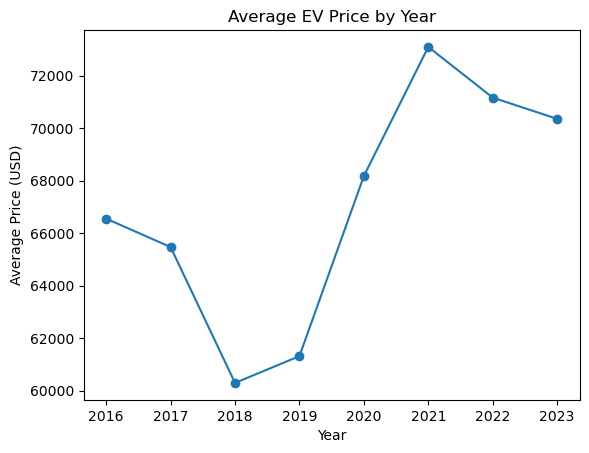

In [15]:
# calculate the average MSRP by year
avg_prices_per_year = pricing_df_sorted.groupby('Year')['MSRP'].mean()

plt.plot(avg_prices_per_year.index, avg_prices_per_year.values, marker='o')
plt.title('Average EV Price by Year')
plt.xlabel('Year')
plt.ylabel('Average Price (USD)')
plt.show()

Here we compute the annual registration and visualize the relationship between the average EV price and total EV registrations over the years on a single chart.

Year
2016     560600.0
2017     754200.0
2018    1145200.0
2019    1567200.0
2020    2037800.0
Name: Electric, dtype: float64


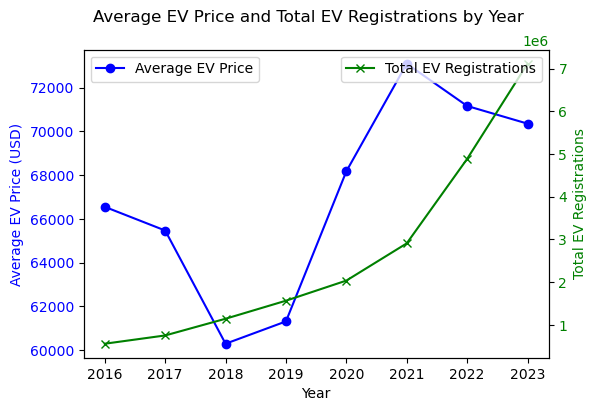

In [16]:
annual_registrations = compiled_df.groupby('Year')['Electric'].sum()
print(annual_registrations.head())

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(6, 4))

# Plot the average EV price with ax1
ax1.set_xlabel('Year')
ax1.set_ylabel('Average EV Price (USD)', color='blue')
ax1.plot(avg_prices_per_year.index, avg_prices_per_year.values, label='Average EV Price', color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for total EV registrations
ax2 = ax1.twinx()
ax2.set_ylabel('Total EV Registrations', color='green')
ax2.plot(annual_registrations.index, annual_registrations.values, label='Total EV Registrations', color='green', marker='x')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and legends
fig.suptitle('Average EV Price and Total EV Registrations by Year')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

Now we want to see the relationship between average EV prices and total EV registrations over the years. A scatter plot is used because it can show whether there's any correlation between the two variables

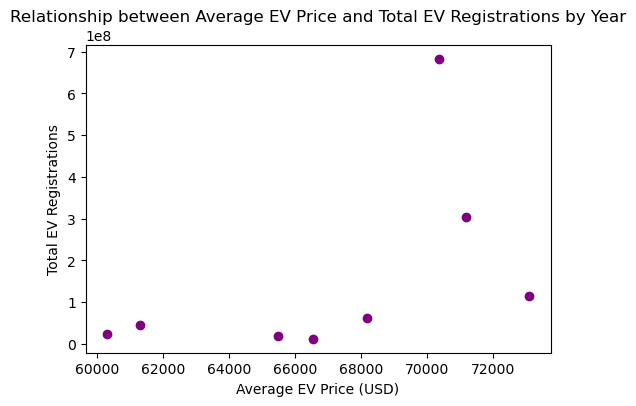

In [17]:
registration_pricing_df = pd.merge(pricing_df_sorted, compiled_df, on='Year', how='inner')

# Group by Year to get the required aggregates
annual_data = registration_pricing_df.groupby('Year').agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

# Plot the relationship using a scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(annual_data['MSRP'], annual_data['Electric'], color='purple', marker='o')

# Add labels and title
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
plt.title('Relationship between Average EV Price and Total EV Registrations by Year')

plt.show()

We also group the registration_pricing_df DataFrame by both 'Year' and 'State' to calculate aggregates for each state in each year. This leads to a scatter plot where we visualize the relationship between average EV price (MSRP) and total EV registrations (Electric) for each state

   Year       State   Electric          MSRP
0  2016     Alabama    11000.0  66551.136364
1  2016      Alaska     4400.0  66551.136364
2  2016     Arizona   103400.0  66551.136364
3  2016    Arkansas     4400.0  66551.136364
4  2016  California  3113000.0  66551.136364


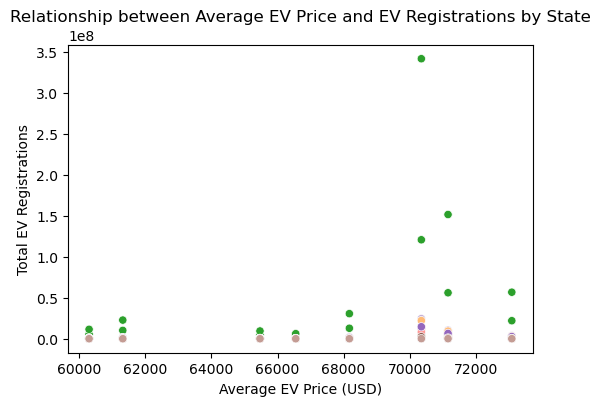

In [18]:
state_annual_data = registration_pricing_df.groupby(['Year', 'State']).agg({'Electric': 'sum', 'MSRP': 'mean'}).reset_index()

print(state_annual_data.head())

plt.figure(figsize=(6, 4))
sns.scatterplot(data=state_annual_data, x='MSRP', y='Electric', hue='State', palette='tab20', legend=False)
plt.title('Relationship between Average EV Price and EV Registrations by State')
plt.xlabel('Average EV Price (USD)')
plt.ylabel('Total EV Registrations')
plt.show()

2. **Electric Vehicle State Incentives**

In [19]:
regis_file_path = os.path.join(current_dir, 'csv_data_files', 'ev_registration_data.csv')
registration_df = pd.read_csv(regis_file_path)

def clean_regis(regis):
    if pd.isna(regis):
        return None
    regis = regis.replace(',', '').strip()
    return float(regis)
    
registration_df['Electric'] = registration_df['Electric'].apply(clean_regis)

We are counting how many active incentives for electric vehicles each state has and creates a scatter plot to show this. It then adds up the number of EV adoptions per state and year, combining this with the incentive counts. Finally, it keeps only the states with active incentives for further analysis.

             State  Active Incentives Count
0          Arizona                        3
1       California                       12
2         Colorado                        5
3      Connecticut                        2
4         Delaware                        3
5          Florida                        2
6          Georgia                        4
7           Hawaii                        2
8         Illinois                        7
9          Indiana                        1
10        Kentucky                        1
11       Louisiana                        1
12           Maine                        2
13        Maryland                        5
14   Massachusetts                        2
15        Michigan                        2
16       Minnesota                        2
17        Missouri                        1
18          Nevada                        1
19      New Jersey                        1
20      New Mexico                        3
21        New York              

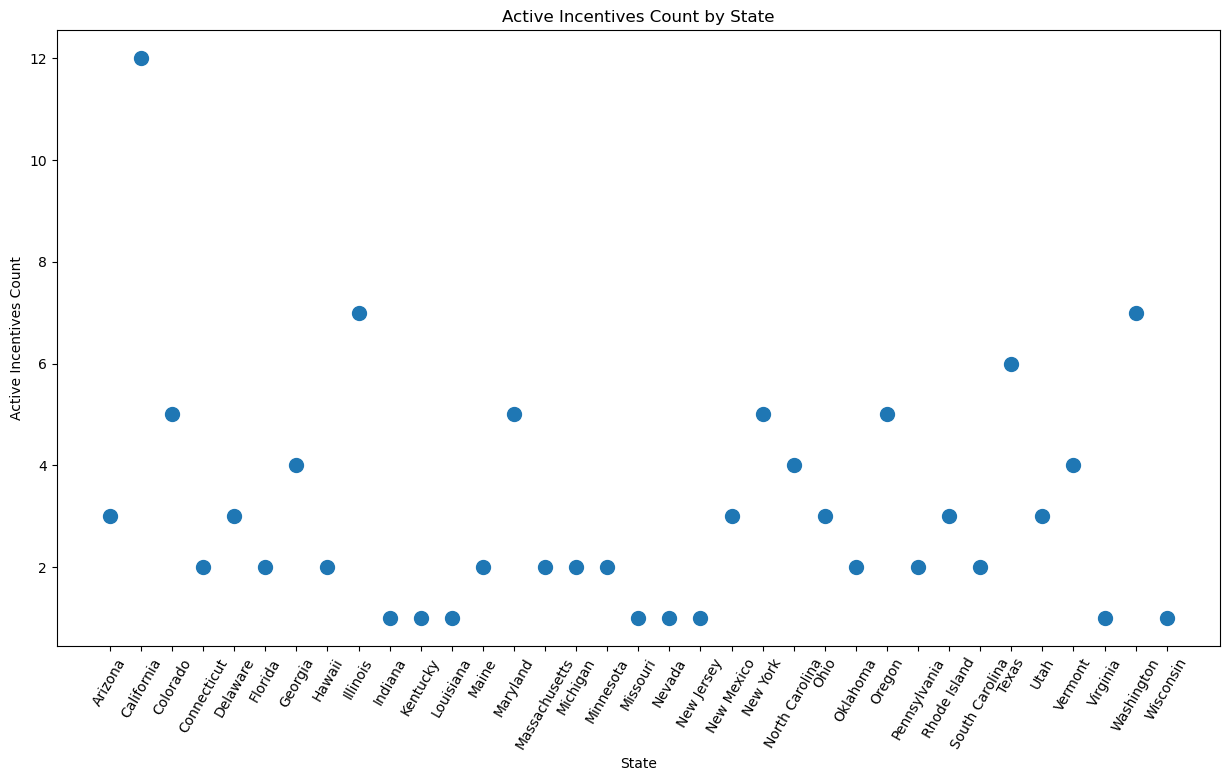

In [20]:
# Count number of active incentives per state 
active_incentives_count = active_state_incentives_df.groupby('State') \
.size().reset_index(name='Active Incentives Count')

print(active_incentives_count)

# Create dataframe with the provided data 
incentives_states_df  = {
    'State': ['Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
              'Georgia', 'Hawaii', 'Illinois', 'Indiana', 'Kentucky', 'Louisiana',
              'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Missouri',
              'Nevada', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Ohio',
              'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'Wisconsin'],
    'Active Incentives Count': [3, 12, 5, 2, 3, 2, 4, 2, 7, 1, 1, 1, 2, 5,
                                2, 2, 2, 1, 1, 1, 3, 5, 4, 3, 2, 5, 2,
                                3, 2, 6, 3, 4, 1, 7, 1]
}

adoption_incentives_df = pd.DataFrame(incentives_states_df )

# Create the scatter plot
# Define the figure size to improve readability
plt.figure(figsize=(15, 8))
plt.plot(adoption_incentives_df['State'], adoption_incentives_df['Active Incentives Count'], 'o', markersize=10)

# Add titles and labels
plt.title('Active Incentives Count by State')
plt.xlabel('State')
plt.ylabel('Active Incentives Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=60)

# Show the plot
plt.show()

# # Sum EV adoptions per state and year from the registration_df
ev_adoptions_per_state = registration_df.groupby(['State', 'Year'])['Electric'] \
.sum().reset_index(name='EV Adoptions')

# Merge incentive counts with EV adoption data
adoptions_incentives_df = ev_adoptions_per_state.merge(active_incentives_count,
                                                       on='State', how='left')
# Filter to include only states with active incentives
adoptions_incentives_df = adoptions_incentives_df[
adoptions_incentives_df['Active Incentives Count'] > 0]

A line plot is created that shows the number of EV adoptions for each state over the years 2016-2023. It loops through the data to draw separate lines for each state to make it easier to see trends over time. The plot also includes a legend that identifies each line by state.

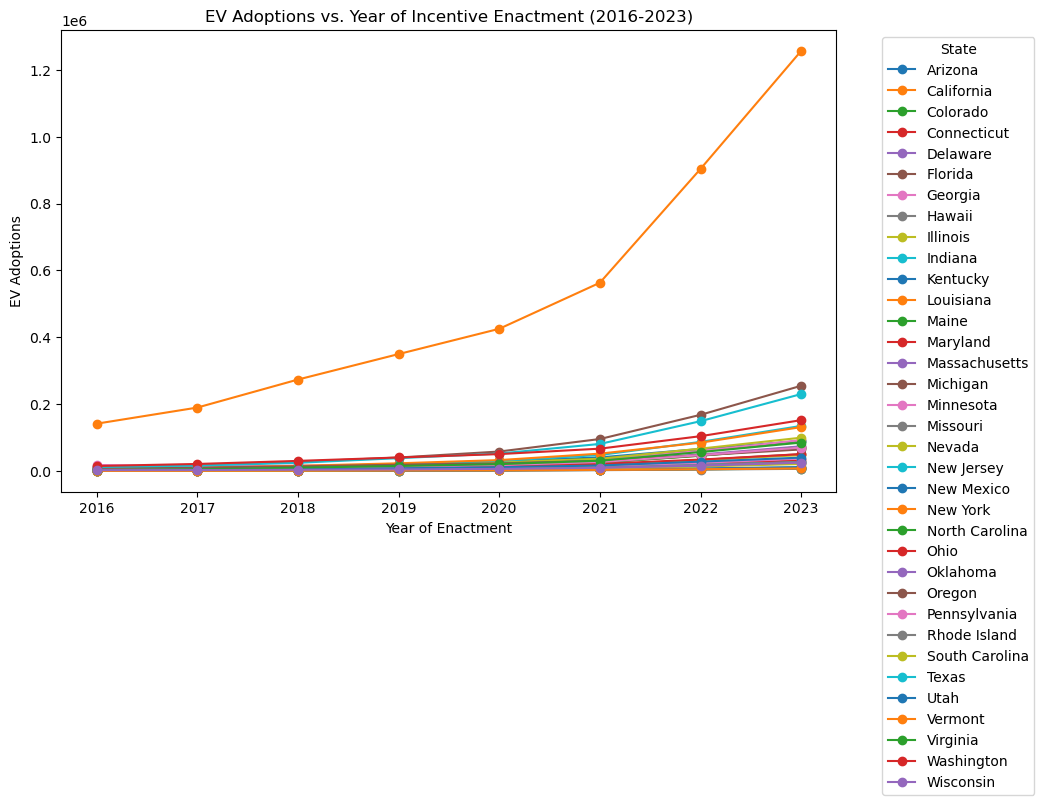

In [21]:
# Create the line plot
plt.figure(figsize=(10, 6))

# Loop through each state to plot their line separately
for state in adoptions_incentives_df['State'].unique():
    state_data = adoptions_incentives_df[adoptions_incentives_df['State'] == state]
    plt.plot(state_data['Year'], state_data['EV Adoptions'], marker='o', label=state)

# Add title and labels
plt.title('EV Adoptions vs. Year of Incentive Enactment (2016-2023)')
plt.xlabel('Year of Enactment')
plt.ylabel('EV Adoptions')

# Show legend
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

We are interested in knowing the total number of EV adoptions per year from 2016 to 2023, particularly for active incentives. It first calculates the sum of EV adoptions for each year across states that have active incentives, then we use this data to plot the overall trend of EV adoption over time, which helps visualize how EV adoptions have changed year by year.

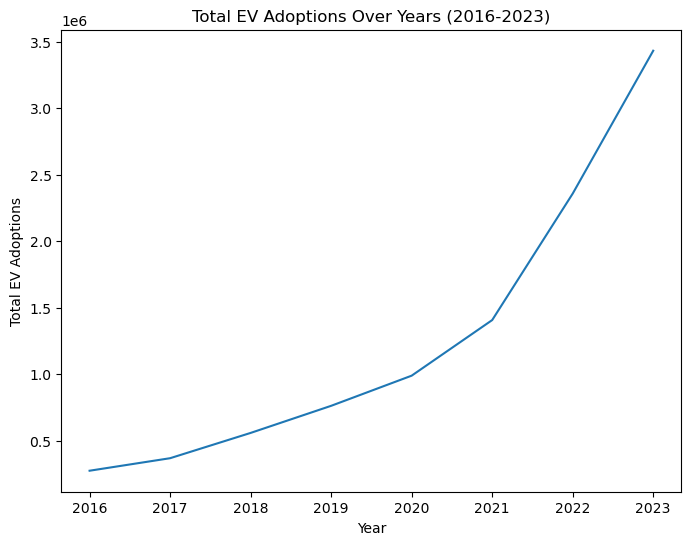

In [22]:
# Sum EV adoptions per year for states with active incentives
yearly_ev_adoptions = registration_df[registration_df['State'].
isin(adoptions_incentives_df['State'])].groupby(['Year'])['Electric'].sum().reset_index()

# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=yearly_ev_adoptions, x='Year', y='Electric')
plt.title('Total EV Adoptions Over Years (2016-2023)')
plt.xlabel('Year')
plt.ylabel('Total EV Adoptions')
plt.show()

4. **Electric Vehicle Charge Stations**


Since 50 states is a lot of data to look at on one graph, let's split into groups of 5 and plot total EV charge stations over time.

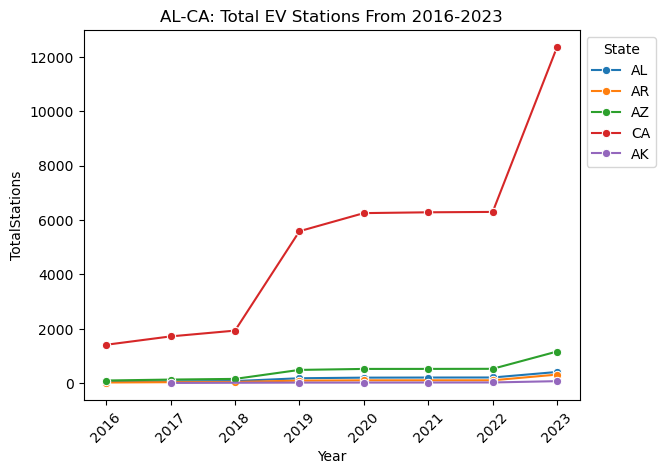

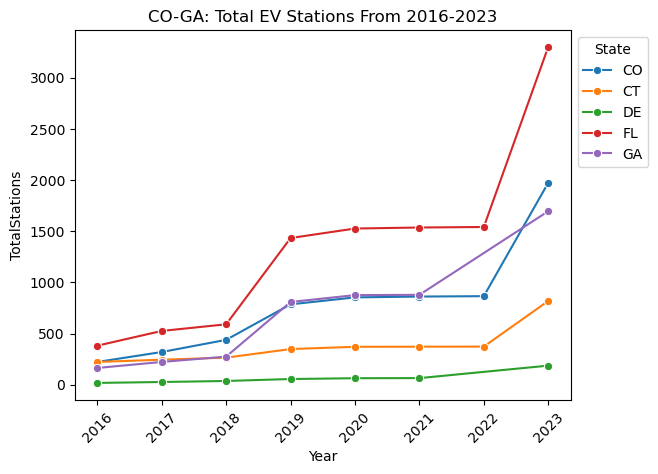

In [23]:
#splitting df to groups of states for plotting
states_to_filter = ['AL', 'AK', 'AZ', 'AR', 'CA']
ocm_us_df_limited_5 = ocm_us_df_limited[ocm_us_df_limited["State"].isin(states_to_filter)]
s = sns.lineplot(data = ocm_us_df_limited_5, \
x = "Year", y = "TotalStations", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("AL-CA: Total EV Stations From 2016-2023")
plt.show()

states_to_filter = ['CO', 'CT', 'DE', 'FL', 'GA']
ocm_us_df_limited_10 = ocm_us_df_limited[ocm_us_df_limited["State"].isin(states_to_filter)]
s = sns.lineplot(data = ocm_us_df_limited_10, \
x = "Year", y = "TotalStations", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.title("CO-GA: Total EV Stations From 2016-2023")
plt.xticks(rotation = 45)
plt.show()

For now, we won't plot every state. Now let's look at TotalStations vs. Total EV Registrations per state.

float64


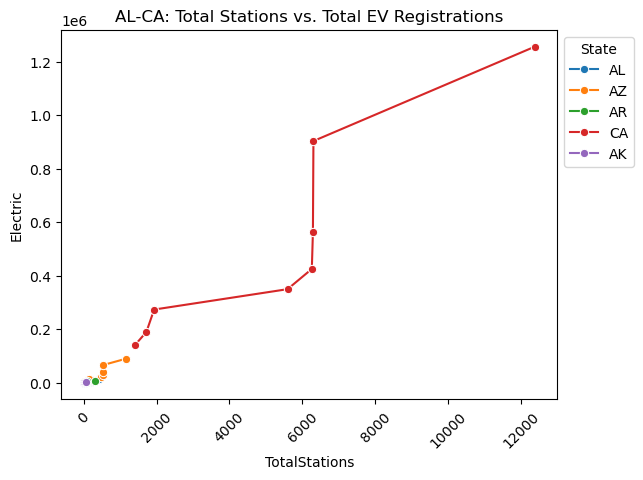

float64


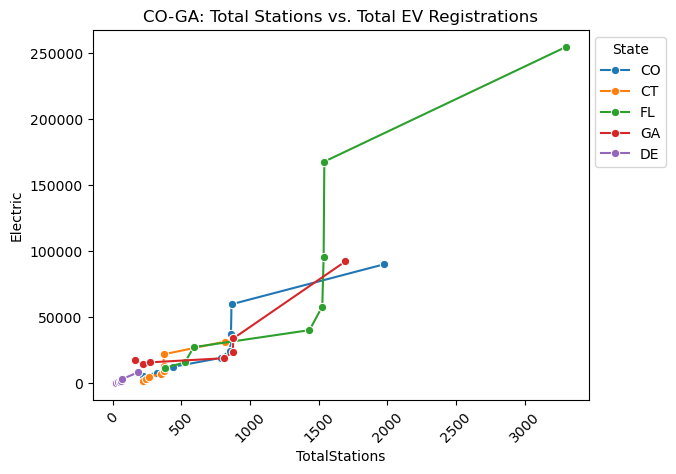

    State  Year  TotalStations  Electric
4      CO  2016            222    5300.0
5      CT  2016            222    2000.0
6      FL  2016            381   11600.0
7      GA  2016            163   18000.0
44     CO  2017            319    8000.0
45     CT  2017            244    3000.0
46     DE  2017             26     400.0
47     GA  2017            222   14400.0
86     CT  2018            264    5000.0
87     DE  2018             36     800.0
88     GA  2018            274   15900.0
127    CO  2019            785   19200.0
128    DE  2019             55    1300.0
169    CO  2020            853   24700.0
170    CT  2020            370    9000.0
171    FL  2020           1526   58200.0
172    GA  2020            875   23500.0
209    CO  2021            861   37000.0
210    CT  2021            371   13300.0
211    DE  2021             64    3000.0
212    FL  2021           1536   95600.0
213    GA  2021            878   34000.0
241    CO  2022            865   59900.0
242    CT  2022 

In [24]:
#splitting df to groups of states for plotting
states_to_filter = ['AL', 'AK', 'AZ', 'AR', 'CA']
combined_df_5 = combined_df[combined_df["State"].isin(states_to_filter)]
print(combined_df_5["Electric"].dtype)
s = sns.lineplot(data = combined_df_5, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("AL-CA: Total Stations vs. Total EV Registrations")
plt.show()

#splitting df to groups of states for plotting
states_to_filter = ['CO', 'CT', 'DE', 'FL', 'GA']
combined_df_10 = combined_df[combined_df["State"].isin(states_to_filter)]
print(combined_df_10["Electric"].dtype)
s = sns.lineplot(data = combined_df_10, \
x = "TotalStations", y = "Electric", marker = "o", hue = "State")
sns.move_legend(s, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.title("CO-GA: Total Stations vs. Total EV Registrations")
plt.show()

print(combined_df_10)
#etc, etc

## Data Limitations:
There are a few limitations in the data we’ve collected:

1. The current dataset only includes information from 2016 to 2023. This relatively narrow time range may hinder our ability to develop a reliable predictive model over a longer horizon. We are exploring additional sources to obtain data from earlier years, which may become more manageable once we narrow our focus to specific states.
2. The dataset is missing information for the year 2023. We are actively looking into potential sources that could help fill this gap.
4. Data only includes charge stations listed on open charge map, which might not include all the charging stations in the US. Data is limited for certain smaller states like Alaska or Delaware, leading to some missed data rows. 
5. Based on the incentives dataset, not all dates provide incentives for electric vehicles, which limits our analysis if we were to consider all states. Additionally, there are missing values in the date columns that could lead to gaps in identifying active incentives.


## Questions For Reviewers: 
* Do we need to explain any external sources referenced like we do in Homework assignments? (e.g. I had to scrape data from a pdf file, which was not covered in class.)
* In the scrapped EV pricing data, some EV model prices are displayed as a range. Currently, I’m calculating the median of the range and using that as the price for the corresponding model. Do you think this is a valid approach, or would you recommend a better method for handling range data?
* Should states without incentives be factored differently in our comparative analysis?
* How do we handle missing data? E.g. if data is missing for Alaska for a year, should we not build a model at all for Alaska? 
